In [1]:
__author__ = 'Team_4'
__Date__ = 'December 2018'

## Load Modules

In [6]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from chainer import Chain, Variable, optimizers
import chainer.functions as F
import chainer.links as L
from copy import deepcopy

import os
__dir__ = os.getcwd()[:-11]

## The LSTM Model

In [63]:
class LSTM(Chain):
    def __init__(self, in_size, hidden_size, hidden2_size, out_size):
        super(LSTM, self).__init__(
            xh=L.EmbedID(in_size, hidden_size),
            hh=L.LSTM(hidden_size, hidden2_size),
            hh2=L.Linear(hidden2_size, hidden2_size),
            hy=L.Linear(hidden2_size, out_size),
        )

    def __call__(self, x, t):
        x = Variable(x)
        t = Variable(t)

        h = self.xh(x)
        h = F.dropout(h,0.3)
        h = F.tanh(h)
        h = self.hh(h)
        h = self.hh2(h)
        h = F.dropout(h,0.3)
        y = F.relu(self.hy(h))

        return F.softmax_cross_entropy(y, t)

    def predict(self, x):
        x = Variable(x)

        h = self.xh(x)
        h = F.tanh(h)
        h = self.hh(h)
        h = self.hh2(h)
        h = F.relu(self.hy(h))
        y = F.softmax(h)

        return y.data

    def reset(self):
        self.hh.reset_state()

## Functions for arrangement

In [64]:
def padding(sentences):
    max_len = np.max([len(s) for s in sentences])
    paded_vec = []
    for sentence in sentences:
        pad_len = max_len - len(sentence)
        pad_vec = [26] * pad_len
        sentence.extend(pad_vec)
        paded_vec.append(sentence)

    return np.array(paded_vec,dtype=np.int32)

def one_hot_encoding(indices,n_class=27):
    return np.eye(n_class)[indices]

def word_to_index(word):
    word_index = [ord (char) - 97 for char in word]
    return word_index

## Preparing the dataset and convert it to vector expression

In [16]:
df = pd.read_csv(__dir__ + 'data/split_point_2.csv',index_col=0)
training_data = np.random.permutation(df.columns.values)
training_data = [word_to_index(x) for x in training_data]

## Defining the LSTM model and setting the optimizer

In [17]:
model = LSTM(27,50,10,27)
optimizer = optimizers.Adam()
optimizer.setup(model)

## Training

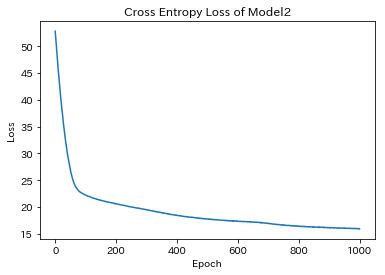

In [18]:
loss_record = []
for i in range(1000):
    model.reset()
    model.cleargrads()
    training_sample = deepcopy(np.random.permutation(training_data))
    training_sample = padding(training_data).T
    loss = 0
    trainX = training_sample[:-1]
    trainY = training_sample[1:]
    for X,Y in zip(trainX,trainY):
        loss += model(X,Y)

    loss_record.append(float(loss.data))
    loss.backward()
    optimizer.update()

plt.plot(loss_record)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Cross Entropy Loss of Model2')
plt.show()

In [30]:
char = np.array(word_to_index('q'))
model.reset()
model.train = False

while True:
    y = model.predict(char)

    pred = np.apply_along_axis(chr,0, np.argsort(y) + 97)[::-1]
    pred = np.where(pred=='{','end',pred)
    prob = np.sort(y)[0][::-1]
    prob = np.round(prob,5)
    cadidate = [(char,p) for char,p in zip(pred[:3],prob[:3])]
    print('input',chr(char[0]+97),':',cadidate)

    char = np.array([np.argmax(y)], dtype=np.int32)

    if char[0] == 26:
        break

input q : [('e', 0.07451), ('p', 0.04977), ('u', 0.04777)]
input e : [('r', 0.16706), ('n', 0.10005), ('m', 0.08876)]
input r : [('e', 0.12631), ('i', 0.10889), ('a', 0.10208)]
input e : [('s', 0.14766), ('d', 0.1434), ('r', 0.13065)]
input s : [('end', 0.22671), ('i', 0.1388), ('s', 0.13801)]


In [62]:
model.reset()
word = 'created'
word_ix = word_to_index(word)
cr_prob = []
var = 0
for char_ix in word_ix:
    y = model.predict(np.array([char_ix]))
    pred = np.apply_along_axis(chr, 0, np.argsort(y) + 97)[::-1]
    pred = np.where(pred=='{','end',pred)
    prob = np.sort(y)[0][::-1]
    prob = np.round(prob,5)
    cadidate = {char:p for char,p in zip(pred[:3],prob[:3])}
    print('input',chr(char_ix+97),':','var:',np.round(np.var(prob),5),np.round(np.var(prob)-var,5),cadidate,)
    var = np.round(np.var(prob),3)

    cr_prob.append(prob[0])

input c : var: 0.00734 0.00734 {'o': 0.45271, 'h': 0.12432, 'e': 0.07645}
input r : var: 0.00476 -0.00224 {'e': 0.29603, 'o': 0.21146, 'i': 0.13978}
input e : var: 0.00069 -0.00431 {'r': 0.09742, 'n': 0.08136, 'a': 0.08105}
input a : var: 0.00208 0.00108 {'n': 0.17934, 'r': 0.15016, 't': 0.10184}
input t : var: 0.00389 0.00189 {'e': 0.28579, 'i': 0.18265, 'a': 0.10825}
input e : var: 0.00388 -0.00012 {'d': 0.23582, 'r': 0.16114, 'n': 0.15939}
input d : var: 0.03069 0.02669 {'end': 0.92988, 's': 0.02474, 'e': 0.01599}
